# Source Classification

## Data Preprocessing

### Match the JSON entries to audio files

In [22]:
import os
import json
from collections import Counter

# Load JSON metadata
with open('../data/examples.json', 'r') as f:
    metadata = json.load(f)

# Define the folder containing audio files
audio_dir = '../data/audio'

# List all .wav files in the audio directory
audio_filenames = set(f.replace('.wav', '') for f in os.listdir(audio_dir) if f.endswith('.wav'))

# Filter JSON entries to only those with matching audio files
matched_entries = {
    key: value for key, value in metadata.items() if key in audio_filenames
}

# Count how many matched entries we have
print(f"Matched {len(matched_entries)} audio files with metadata.")


Matched 4096 audio files with metadata.


### Examine unique classes in instrument source

In [23]:
# Count the class distribution in 'instrument_source_str'
source_counter = Counter(entry['instrument_source_str'] for entry in matched_entries.values())

# Display unique classes and their counts
print("Class distribution in instrument_source_str:")
for source, count in source_counter.items():
    print(f"  {source}: {count}")

# Get a mapping for class labels
source_to_label = {name: i for i, name in enumerate(sorted(source_counter))}
print("\nClass label mapping:")
print(source_to_label)

Class distribution in instrument_source_str:
  synthetic: 1035
  electronic: 1372
  acoustic: 1689

Class label mapping:
{'acoustic': 0, 'electronic': 1, 'synthetic': 2}


### Create Train/Val/Test Split

In [24]:
import random
from sklearn.model_selection import train_test_split

# Set seed for reproducibility
random.seed(6600)

# Create a list of matched (key, label) pairs
all_data = [(key, source_to_label[meta["instrument_source_str"]])
            for key, meta in matched_entries.items()]

# Split into train (60%), val (20%), test (20%)
train_val, test = train_test_split(all_data, test_size=0.20, stratify=[label for _, label in all_data], random_state=6600)
train, val = train_test_split(train_val, test_size=0.25, stratify=[label for _, label in train_val], random_state=6600)

print(f"Train: {len(train)}  Val: {len(val)}  Test: {len(test)}")

Train: 2457  Val: 819  Test: 820


### PyTorch Dataset & Dataloader

In [25]:
import librosa
import torch
from torch.utils.data import Dataset, DataLoader

class NSynthWaveformDataset(Dataset):
    def __init__(self, data_list, json_data, audio_dir, transform=None):
        self.data_list = data_list
        self.json_data = json_data
        self.audio_dir = audio_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        key, label = self.data_list[idx]
        path = os.path.join(self.audio_dir, f"{key}.wav")
        
        waveform, sr = librosa.load(path, sr=16000)
        waveform = torch.tensor(waveform).unsqueeze(0)  # [1, 64000]
        
        if self.transform:
            waveform = self.transform(waveform)
        return waveform, label


# Create Dataloaders
batch_size = 16

train_ds = NSynthWaveformDataset(train, metadata, audio_dir)
val_ds = NSynthWaveformDataset(val, metadata, audio_dir)
test_ds = NSynthWaveformDataset(test, metadata, audio_dir)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)
test_loader = DataLoader(test_ds, batch_size=batch_size)

## Model Architecture - 1D CNN

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AudioCNN(nn.Module):
    def __init__(self, input_length=64000, n_classes=3):
        super(AudioCNN, self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.MaxPool1d(4),

            nn.Conv1d(16, 32, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(4),

            nn.Conv1d(32, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(4),
        )
        
        # Calculate output size after conv layers
        dummy_input = torch.zeros(1, 1, input_length)
        out = self.conv_layers(dummy_input)
        flattened_size = out.shape[1] * out.shape[2]
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, n_classes)
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


- Input: 1D waveform of shape (batch_size, 1, 64000).
- Output: Logits of shape (batch_size, 3) for the 3 classes.
- BatchNorm and Dropout help with generalization.

### Build training loop

In [27]:
import torch
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AudioCNN().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

def train_epoch(model, loader):
    model.train()
    total_loss, all_preds, all_labels = 0, [], []
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        preds = model(x)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        all_preds.append(preds.argmax(dim=1).cpu())
        all_labels.append(y.cpu())
    
    avg_loss = total_loss / len(loader.dataset)
    acc = accuracy_score(torch.cat(all_labels), torch.cat(all_preds))
    return avg_loss, acc

### Evaluation metrics

In [28]:
def eval_epoch(model, loader):
    model.eval()
    total_loss, all_preds, all_labels = 0, [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            preds = model(x)
            loss = criterion(preds, y)

            total_loss += loss.item() * x.size(0)
            all_preds.append(preds.argmax(dim=1).cpu())
            all_labels.append(y.cpu())
    
    avg_loss = total_loss / len(loader.dataset)
    acc = accuracy_score(torch.cat(all_labels), torch.cat(all_preds))
    return avg_loss, acc, torch.cat(all_preds), torch.cat(all_labels)

## Train the model

In [29]:
# Training Loop
num_epochs = 20
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader)
    val_loss, val_acc, _, _ = eval_epoch(model, val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.3f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.3f}")

Epoch 1/20 | Train Loss: 2.9015, Acc: 0.438 | Val Loss: 1.0060, Acc: 0.491
Epoch 2/20 | Train Loss: 1.0067, Acc: 0.459 | Val Loss: 0.9819, Acc: 0.487
Epoch 3/20 | Train Loss: 0.9913, Acc: 0.464 | Val Loss: 0.9488, Acc: 0.491
Epoch 4/20 | Train Loss: 0.9833, Acc: 0.465 | Val Loss: 0.9213, Acc: 0.499
Epoch 5/20 | Train Loss: 0.9243, Acc: 0.493 | Val Loss: 0.9185, Acc: 0.502
Epoch 6/20 | Train Loss: 0.9217, Acc: 0.498 | Val Loss: 0.9188, Acc: 0.513
Epoch 7/20 | Train Loss: 0.9285, Acc: 0.511 | Val Loss: 0.8145, Acc: 0.541
Epoch 8/20 | Train Loss: 0.8742, Acc: 0.528 | Val Loss: 0.7773, Acc: 0.624
Epoch 9/20 | Train Loss: 0.8413, Acc: 0.536 | Val Loss: 0.7727, Acc: 0.621
Epoch 10/20 | Train Loss: 0.7799, Acc: 0.575 | Val Loss: 0.6862, Acc: 0.643
Epoch 11/20 | Train Loss: 0.7822, Acc: 0.589 | Val Loss: 0.7935, Acc: 0.526
Epoch 12/20 | Train Loss: 0.7543, Acc: 0.595 | Val Loss: 0.6307, Acc: 0.705
Epoch 13/20 | Train Loss: 0.7289, Acc: 0.626 | Val Loss: 0.6466, Acc: 0.667
Epoch 14/20 | Train L

### Plot Training & Validation Curves

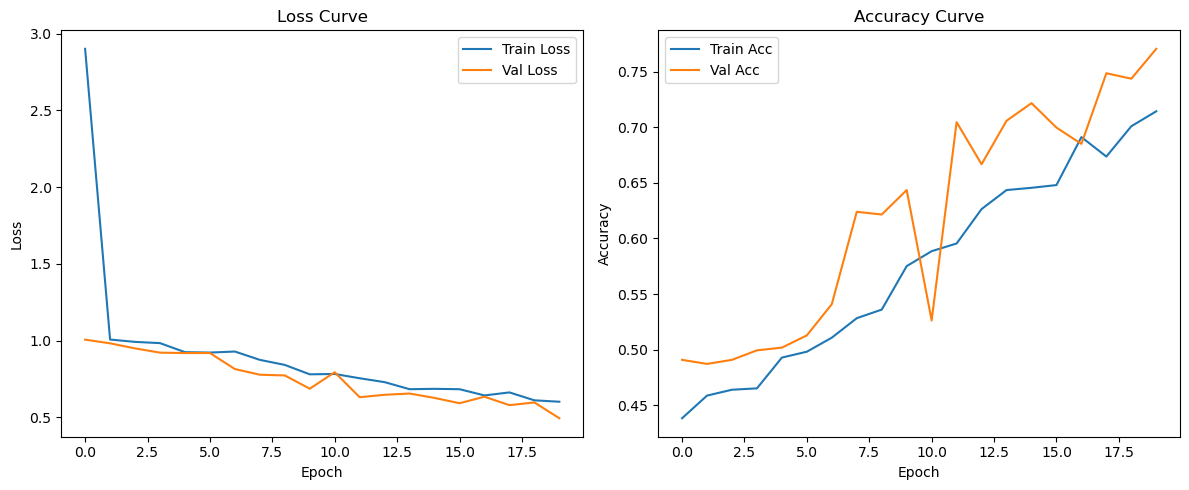

In [30]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## Evaluation

### Final Test Evaluation + Confusion Matrix

Test Accuracy: 0.8195


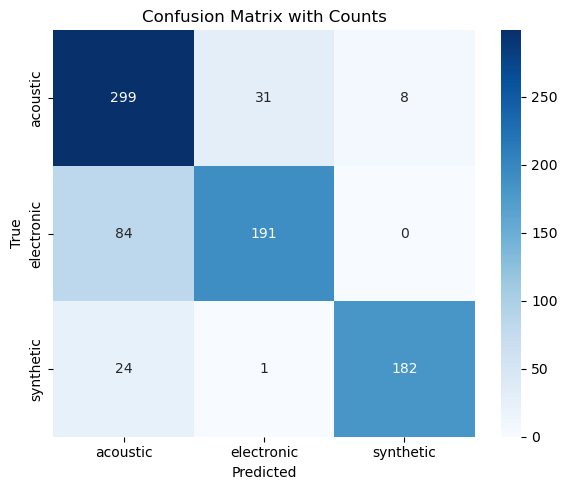

In [33]:
_, test_acc, test_preds, test_labels = eval_epoch(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f}")

# Confusion Matrix
import seaborn as sns
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(6, 5))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=["acoustic", "electronic", "synthetic"],
            yticklabels=["acoustic", "electronic", "synthetic"])

plt.title("Confusion Matrix with Counts")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

## Conclusion

Our 1D CNN model for source classification achieved strong performance, with a final test accuracy of 81.95% in distinguishing between acoustic, electronic, and synthetic sound sources. Over the 20 training epochs, both training and validation accuracy consistently improved, and validation loss steadily declined, indicating effective learning without overfitting.

The confusion matrix shows that the model performs particularly well in identifying acoustic and synthetic sources, with minor confusion between electronic and the other categories—likely due to overlapping signal structures in some cases. 

Overall, the waveform-based approach effectively captures temporal patterns unique to each source type, confirming that 1D CNNs are well-suited for source classification tasks using raw audio waveforms.